In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


Hello there, 
* I have tried to explain every step in simple manner.
* Feel free to comment if you find anything wrong or have any doubts, would be happy to help :D
* Do read the Data Dictionary properly before attempting the competition

#### Importing all necessary packages

In [2]:
#for basic analysis
import pandas as pd
import numpy as np

#for visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#for stats & modelling
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
#read the data into pandas dataframe
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")

# Exploratory Data Analysis

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

I have created a series of User Defined Functions (UDFs)
* to better understand our data, do descriptive analysis of data
* and also make it easy for doing some preprocessing steps such as outlier, missing value treatments etc.

In [6]:
# UDF for descriptive analysis of numeric vars.
def con_stats(c):
    return pd.Series({'Count':c.count(),'NaNs':c.isnull().sum(),'%NaNs':c.isnull().sum()*100/c.shape[0],'Sum':c.sum(),'Mean':c.mean(),'Std.Dev':c.std(),
                      'Coef.of.Var':c.std()/c.mean(),'Min':c.min(),'P1':c.quantile(.01),'P5':c.quantile(.05),'P10':c.quantile(.1),'P25':c.quantile(.25),
                      'P50':c.quantile(.5),'P90':c.quantile(.9),'P95':c.quantile(.95),'P99':c.quantile(.99),'Max':c.max()})

In [7]:
# UDF for descriptive analysis for categorical vars
def cat_stats(v):
    return pd.Series({'Count':v.count(),'NaNs':v.isnull().sum(),'%NaNs':v.isnull().sum()*100/v.shape[0],'#.Uniques':v.unique().shape[0],
                     'Mode':v.mode()[0]})

In [8]:
# UDF for Missing Value treatment 
def miss(m):
    if (m.dtype=='int64')|(m.dtype=='float64'):
        m.fillna(m.mean(),inplace=True)
    elif m.dtype=='object':
        m.fillna(m.mode()[0],inplace=True)  #m.mode()[0] means, fill with first occurence of mode incase of multimodal
    return m

In [9]:
# UDF for outlier treatment
def outs(o):
    if (o.dtype=='int64')|(o.dtype=='float64'):
        o.clip(lower=o.quantile(0.01), upper=o.quantile(0.95), inplace=True)
        return o
    else:
        return o

In [10]:
# UDF for dummy var creation
def dums(d):
    d=pd.get_dummies(d,drop_first=True, prefix='Dum')
    return d

In [11]:
#don't need ID column for analysis
train.drop(columns=['Id'],inplace=True)

In [12]:
train.select_dtypes(exclude='object').apply(con_stats).T.round(2)

,Count,NaNs,%NaNs,Sum,Mean,Std.Dev,Coef.of.Var,Min,P1,P5,P10,P25,P50,P90,P95,P99,Max
MSSubClass,1460.0,0.0,0.00,83070.0,56.90,42.30,0.74,20.0,20.00,20.00,20.0,20.00,50.0,120.0,160.00,190.00,190.0
LotFrontage,1201.0,259.0,17.74,84130.0,70.05,24.28,0.35,21.0,21.00,34.00,44.0,59.00,69.0,96.0,107.00,141.00,313.0
LotArea,1460.0,0.0,0.00,15354569.0,10516.83,9981.26,0.95,1300.0,1680.00,3311.70,5000.0,7553.50,9478.5,14381.7,17401.15,37567.64,215245.0
OverallQual,1460.0,0.0,0.00,8905.0,6.10,1.38,0.23,1.0,3.00,4.00,5.0,5.00,6.0,8.0,8.00,10.00,10.0
OverallCond,1460.0,0.0,0.00,8140.0,5.58,1.11,0.20,1.0,3.00,4.00,5.0,5.00,5.0,7.0,8.00,9.00,9.0
YearBuilt,1460.0,0.0,0.00,2878051.0,1971.27,30.20,0.02,1872.0,1899.18,1916.00,1924.9,1954.00,1973.0,2006.0,2007.00,2009.00,2010.0
YearRemodAdd,1460.0,0.0,0.00,2897904.0,1984.87,20.65,0.01,1950.0,1950.00,1950.00,1950.0,1967.00,1994.0,2006.0,2007.00,2009.00,2010.0
MasVnrArea,1452.0,8.0,0.55,150551.0,103.69,181.07,1.75,0.0,0.00,0.00,0.0,0.00,0.0,335.0,456.00,791.92,1600.0
BsmtFinSF1,1460.0,0.0,0.00,647714.0,443.64,456.10,1.03,0.0,0.00,0.00,0.0,0.00,383.5,1065.5,1274.00,1572.41,5644.0
BsmtFinSF2,1460.0,0.0,0.00,67962.0,46.55,161.32,3.47,0.0,0.00,0.00,0.0,0.00,0.0,117.2,396.20,830.38,1474.0


The above is an insightfull descriptive stats of numeric datatype in our train data.
* 3 variables have null values
* few variables have very low Coefficient of variation, eg : YrSold, GarageYrBlt, YearBuilt etc. I would drop vars. with Coef.of Var less than 0.1.
* There are significant outliers on the upper side (eg : LotArea)

In [13]:
train.drop(columns = ['YrSold','GarageYrBlt','YearBuilt','YearRemodAdd'], inplace=True)

In [14]:
train.select_dtypes(include='object').apply(cat_stats).T

,Count,NaNs,%NaNs,#.Uniques,Mode
MSZoning,1460,0,0,5,RL
Street,1460,0,0,2,Pave
Alley,91,1369,93.7671,3,Grvl
LotShape,1460,0,0,4,Reg
LandContour,1460,0,0,4,Lvl
Utilities,1460,0,0,2,AllPub
LotConfig,1460,0,0,5,Inside
LandSlope,1460,0,0,3,Gtl
Neighborhood,1460,0,0,25,NAmes
Condition1,1460,0,0,9,Norm


* many object type vars has nulls
* few vars. have more than 50% nulls, but we won't drop them rightaway !

#### IMP. NOTE 1:
* according to the data dictionary, NaNs in object type has a meaning -
* for eg. look at "Alley" in above output, it has 1369 NaNs, and according to data dictionary NA in Alley means that particular house has NO alley
* similarly for FireplaceQu, POOLQC and so on.
* so, a house with NO POOL or NO Alley should cost less than the one with a POOL or Alley (provided all other features are same between them)
* so instead of blindly filling the NaNs, we replace the NaNs with "NONE" to take into consideration the fact that said feature is absent in that house  while calculating sale price.
* The above has been implemented in below code 

In [15]:
x=train[['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
'PoolQC','Fence','MiscFeature']].copy()

train.drop(columns=['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
'PoolQC','Fence','MiscFeature'],inplace=True)

x.fillna('None',inplace=True)

train=pd.concat([train,x],axis=1)

In [16]:
train.isnull().any().any()

True

In [17]:
#train.GarageYrBlt.fillna(train.GarageYrBlt.mode()[0],inplace=True)  #don't want to fill year with mean value of year
train=train.apply(miss)

In [18]:
train.isnull().any().any()

False

Text(0.5, 0.98, 'Plots showing Outliers')

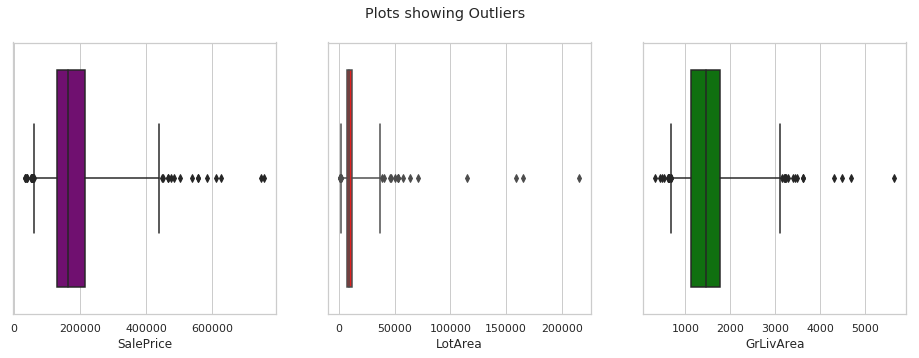

In [19]:
# Outlier Treatment 
sns.set(style='whitegrid')
f,ax=plt.subplots(1,3,figsize=(16,5))
sns.boxplot(train.SalePrice,ax=ax[0],color='purple', whis=[1,99])
sns.boxplot(train.LotArea,ax=ax[1],color='red', whis=[1,99])
sns.boxplot(train.GrLivArea,ax=ax[2],color='green', whis=[1,99])
plt.suptitle('Plots showing Outliers')

**BOXPLOTS & OUTLIERS EXPLAINED**
* The above plots are boxplots, which show distribution of data.
* Boxplots explains if our data is symmetrical (box should be in middle), quantiles/percentiles and most importantly it explains outliers (the tiny dots either side of the line).
* OUTLIERS : these are data points that are different from the majority of the group (differenet in terms of their value), consider them to be abnormal data points (eg : in a class of 30 students, 28 students have age in the range 16-18, while 2 students are aged 38 & 40, these 2 students are outliers)
* In the SalePrice boxplot the line just above 400000 on x-axis corresponds to 99th percentile (the black vertical line on right side of purple box), meaning 99% of SalePrice data is below 400000. BUT there are many data points to the right of this 99th percentile, which are treated as outliers as their values are significantly higher from the majority of the group.
* Similarly outliers are on the lower side also, which shall be treated too.
* How to treat --> "clipping" the outlier data points to 99th and 1st percentiles, i.e. the dots which you see to the right of that verticle line will be clipped to that line/will fall on that line after clipping.
* Why treat outliers --> if not treated, our analysis will be biased, a handfull of significantly high value data points can affect our model to large extent.

In [20]:
# treating outliers, by clipping them to 1st and 95th percentiles
train=train.apply(outs)

Text(0.5, 0.98, 'Post outlier treatment')

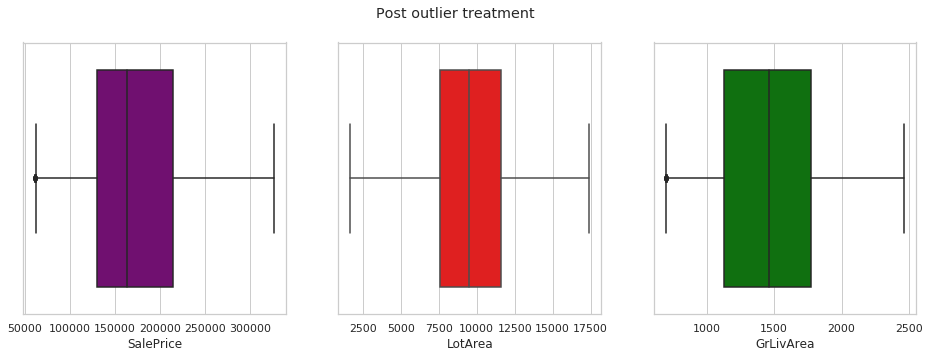

In [21]:
f,ax=plt.subplots(1,3,figsize=(16,5))
sns.boxplot(train.SalePrice,ax=ax[0],color='purple', whis=[1,99])
sns.boxplot(train.LotArea,ax=ax[1],color='red', whis=[1,99])
sns.boxplot(train.GrLivArea,ax=ax[2],color='green', whis=[1,99])
plt.suptitle('Post outlier treatment')

#### IMP. Note 2:
* there are sevaral features such as ExterQual, ExterCond, BsmtQual etc. which are ordinal in nature, i.e the values of these features are ranked.
* for eg : BsmtQual has the following unique categories :
    * Ex	Excellent (100+ inches)	
    * Gd	Good (90-99 inches)
    * TA	Typical (80-89 inches)
    * Fa	Fair (70-79 inches)
    * Po	Poor (<70 inches
    * NA	No Basement      (remember we filled such NAs with 'None')
* so, "Ex" should have a higher rank than "Gd", "TA", "Fa" so on. Hence we will rank/encode "Ex" with a higher number (highest rank) compared to Gd and so on.
* higher number indicates higher rank in our analysis.
* we shall do this above step for all such ordinal features.

In [22]:
mapper = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5,
          'No':1, 'Mn':2, 'Av':3,
          'Unf':1,'LwQ':2, 'Rec':3, 'BLQ':4,'ALQ':5, 'GLQ':6,
          'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3,
          'ELO':0, 'NoSeWa':1, 'NoSewr':2, 'AllPub':3,
          'Low':0,'HLS':1,'Bnk':2, 'Lvl':3,
          'Sev':0, 'Mod':1, 'Gtl':2,
          'MnWw':1,'GdWo':2, 'MnPrv':3,'GdPrv':4,
          'RFn':2,'Fin':3,
          'Pave':1,'Grvl':2,
          'N':0,'P':1,'Y':2}

def ranker(c):
    c=c.map(mapper)
    return c

In [23]:
ranked_vars = train[['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','FireplaceQu','GarageQual',
 'GarageCond','PoolQC','LotShape', 'Utilities','LandContour','LandSlope','Fence','GarageFinish','Street','Alley','CentralAir','PavedDrive']].apply(ranker)

ranked_vars.head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,...,LotShape,Utilities,LandContour,LandSlope,Fence,GarageFinish,Street,Alley,CentralAir,PavedDrive
0,4,3,4,3,1,6,1,5,4,0,...,3,3,3,2,0,2,1,0,2,2
1,3,3,4,3,4,5,1,5,3,3,...,3,3,3,2,0,2,1,0,2,2
2,4,3,4,3,2,6,1,5,4,3,...,2,3,3,2,0,2,1,0,2,2
3,3,3,3,4,1,5,1,4,4,4,...,2,3,3,2,0,1,1,0,2,2
4,4,3,4,3,3,6,1,5,4,3,...,2,3,3,2,0,2,1,0,2,2


In [24]:
train.drop(columns=['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','FireplaceQu','GarageQual',
 'GarageCond','PoolQC','LotShape', 'Utilities','LandContour','LandSlope','Fence','GarageFinish','Street','Alley','CentralAir','PavedDrive'],inplace=True)  # dropping original columns

In [25]:
train=pd.concat([train,ranked_vars],axis=1) #concatenating new ordinal vars

In [26]:
train=dums(train)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 201 entries, MSSubClass to Dum_TenC
dtypes: float64(11), int64(45), uint8(145)
memory usage: 845.6 KB


# Essential Assumptions Check

While doing prediction, which involves regresseion technique there are few assumptions whih should hold true, and out of them the following are essential.

#### 1. Normality of Target 
* A.q.d to this, our target should be following normal distribution/bell curve, if not apply log transform to make it follow bell curve.

Skewness : 0.7422508465880165


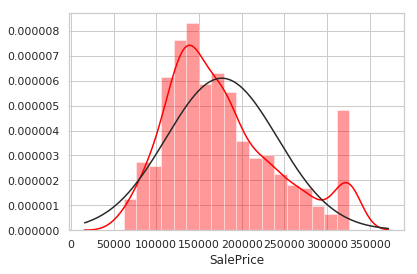

In [28]:
# Normality of target
sns.set(style='whitegrid')
sns.distplot(train.SalePrice, fit=stats.norm,color='red')
print('Skewness :',stats.skew(train.SalePrice))   # still skewed even after outlier treatment

* Our target is highly skewed, hence apply log transform on it.

Skewness : -0.06532352176475549


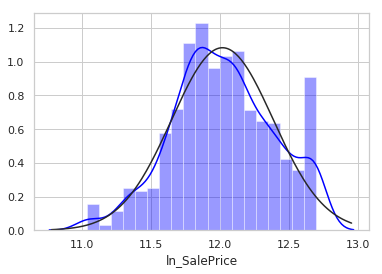

In [29]:
#applying log transform on target
train['ln_SalePrice']=np.log1p(train.SalePrice)
sns.distplot(train.ln_SalePrice, fit=stats.norm, color='blue')
print('Skewness :',stats.skew(train.ln_SalePrice))

#### 2. Linearity with Target
* Aqd to this, the features should be in linear relationship with our target, as shown below.
* Various machine learning models, adjust the importance of features based on their relation with target (eg : random forests etc.)

Text(0.5, 0.98, 'Linearity with Target')

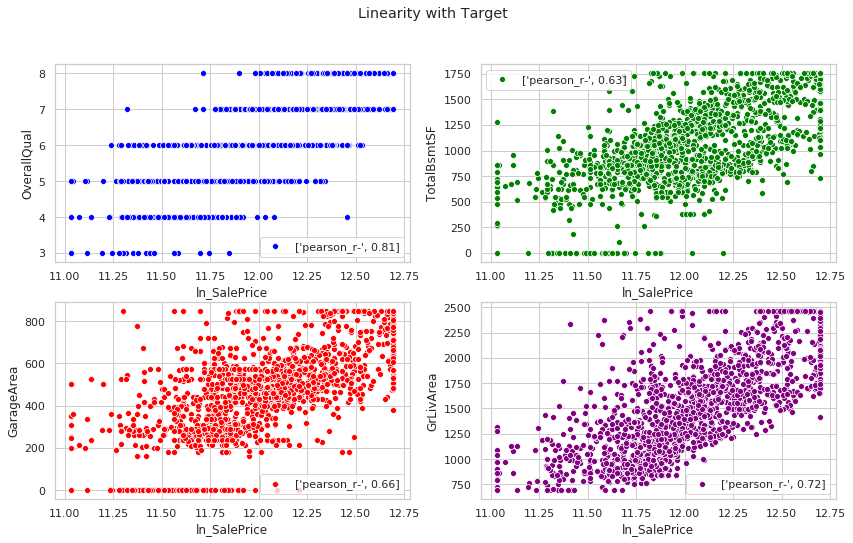

In [30]:
# Linearity with target
f1,ax=plt.subplots(2,2,figsize=(14,8))
p1=(stats.pearsonr(train.OverallQual, train.ln_SalePrice)[0])
sns.scatterplot(y='OverallQual',x='ln_SalePrice',data=train,ax=ax[0,0],label=['pearson_r-', p1.round(2)],color='blue')
p2=(stats.pearsonr(train.TotalBsmtSF, train.ln_SalePrice)[0])
sns.scatterplot(y='TotalBsmtSF',x='ln_SalePrice',data=train,ax=ax[0,1],label=['pearson_r-', p2.round(2)],color='green')
p3=(stats.pearsonr(train.GarageArea, train.ln_SalePrice)[0])
sns.scatterplot(y='GarageArea',x='ln_SalePrice',data=train,ax=ax[1,0],label=['pearson_r-', p3.round(2)],color='red')
p4=(stats.pearsonr(train.GrLivArea, train.ln_SalePrice)[0])
sns.scatterplot(y='GrLivArea',x='ln_SalePrice',data=train,ax=ax[1,1],label=['pearson_r-', p4.round(2)],color='purple')
plt.suptitle('Linearity with Target')

* as seen above there are certain features that show linearity with the target, i.e the value of SalePrice (target) increases as the value of the said features increases too.
* to get insight on which feature show linearity with target, I use pearson-r as below, which describes the linear relationship

In [31]:
f=[]

for i in train.select_dtypes(exclude='uint8').columns:
    f.append(stats.pearsonr(train[i],train.ln_SalePrice)[0].round(2))

pr_df=pd.DataFrame({'Features':train.select_dtypes(exclude='uint8').columns, 'Pearson_r':f})
pr_df.sort_values(by='Pearson_r',ascending=False)[0:18]  # top 18 which shows very high linearity with target

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,Features,Pearson_r
56,ln_SalePrice,1.00
32,SalePrice,0.98
3,OverallQual,0.81
13,GrLivArea,0.72
22,GarageCars,0.69
33,ExterQual,0.67
23,GarageArea,0.66
41,KitchenQual,0.66
9,TotalBsmtSF,0.63
35,BsmtQual,0.62


* as seen above, most features are linearly related to our target, which is good.

In [32]:
train.drop(columns=['LowQualFinSF','KitchenAbvGr','3SsnPorch','PoolArea','MiscVal'],inplace=True) 
#removing these as they filled with only zeros and are like redundant variables (POOL AREA taken care by POOLQC)

#### 3. Absence of MultiCollinearity
* Aqd to this assumption, multicollinearity i.e relation among the features themselves should be low (idealy absent) .

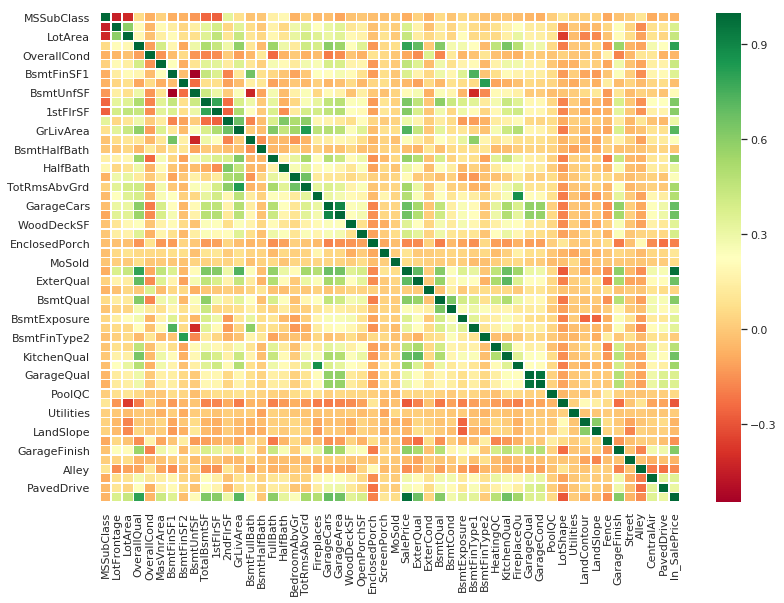

In [33]:
# Multicollinearity
cormat=train.select_dtypes(exclude='uint8').corr()
plt.figure(figsize=(13,9))
sns.heatmap(cormat,linewidths=.5, cmap='RdYlGn')

Yhe above heatmap is useful :
* It not only explains multicollinearity but also correlation of features with target
* NOTE : for regression techniques we want to reduce multi collinearity
* in above the blocks with color yellow(ish) are low while red and green indicate high multicollinearity.
* There are multiple ways to deal with this which include dropping variables,PCA,FACTOR ANALYSIS, VIF etc. BUT using tree, ensemble based models takes care of this on its own.

# Modelling

MODELS employed :
* Linear Regression
* Ridge Regression
* Decision Tree Regressor
* Random Forest Regressor

#### Scaling the data 
* why scale : as we saw value of SalePrice (target) is in thousands, while many other features are not in the same scale, hence we scale all data, to bring all observations under same scale
* MinMax scaler employed, subtracts the minimum value & divides by range
* it preserves the distribution of the feature, without making any major changes to info. content of the feature

In [34]:
mm=MinMaxScaler()
scaled=mm.fit_transform(train)

In [35]:
scaled

array([[0.28571429, 0.53012048, 0.43063007, ..., 0.        , 0.        ,
        0.73105505],
       [0.        , 0.71084337, 0.50377994, ..., 0.        , 0.        ,
        0.64766345],
       [0.28571429, 0.56626506, 0.60873409, ..., 0.        , 0.        ,
        0.77282945],
       ...,
       [0.35714286, 0.54216867, 0.46828635, ..., 1.        , 0.        ,
        0.87863764],
       [0.        , 0.56626506, 0.51122214, ..., 0.        , 0.        ,
        0.50061421],
       [0.        , 0.65060241, 0.52521603, ..., 0.        , 0.        ,
        0.52293551]])

In [36]:
# create dataframe of the scaled features
train=pd.DataFrame(scaled, columns=train.columns)
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Dum_Basment,Dum_BuiltIn,Dum_CarPort,Dum_Detchd,Dum_None,Dum_None,Dum_Othr,Dum_Shed,Dum_TenC,ln_SalePrice
0,0.285714,0.530120,0.430630,0.8,0.4,0.429825,0.554160,0.0,0.102180,0.488306,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.731055
1,0.000000,0.710843,0.503780,0.6,1.0,0.000000,0.767661,0.0,0.193460,0.719909,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.647663
2,0.285714,0.566265,0.608734,0.8,0.4,0.355263,0.381476,0.0,0.295640,0.524815,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.772829
3,0.357143,0.469880,0.500600,0.8,0.4,0.000000,0.169545,0.0,0.367847,0.431261,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.491556
4,0.285714,0.759036,0.800196,1.0,0.4,0.767544,0.514129,0.0,0.333787,0.653166,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.840206


In [37]:
# we'll work with ln_SalePrice now onwards
original_SalePrice=train.SalePrice.copy()
train.drop(columns=['SalePrice'], inplace=True)

In [38]:
train.shape

(1460, 196)

In [39]:
# separating feature variables & target
X = train[train.columns.difference(['ln_SalePrice'])]
y = train['ln_SalePrice']

In [40]:
# train test split, this splits the train data in train(70):test(30) ratio
train_X,test_X,train_y,test_y = train_test_split(X,y, test_size=0.3, random_state=12345)

**Idea behind doing train - test split :**
* we will train/fit our model on train data, so our model has seen / or has been subjected to pattern in train data 
* but the model has not seen test data (since we haven't trained the model on test) so here, test data functions as a completely new data(UNSEEN DATA) for our model
* any good model should yield good, consistant results for both train and test data (an optimised model)

### Simple Linear Regression

In [41]:
lr=LinearRegression()
lr.fit(train_X,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
#prediction for train and test
lr_pred = lr.predict(train_X)
lr_test_pred = lr.predict(test_X)

In [43]:
# evaluation metrics calculation
train_lr_mse = metrics.mean_squared_error(train_y,lr_pred).round(3)
train_lr_mae = metrics.mean_absolute_error(train_y,lr_pred).round(3)
train_lr_r2 = metrics.r2_score(train_y,lr_pred).round(3)

test_lr_mae = metrics.mean_absolute_error(test_y,lr_test_pred).round(3)
test_lr_mse = metrics.mean_squared_error(test_y,lr_test_pred).round(3)
test_lr_r2 = metrics.r2_score(test_y,lr_test_pred).round(3)

In [44]:
lin_reg_eva= pd.DataFrame(index=['R2','MAE','MSE'],columns=['Train','Test'],data=[[train_lr_r2,test_lr_r2],[train_lr_mae,test_lr_mae],
                                                                                 [train_lr_mse,test_lr_mse]])
lin_reg_eva

,Train,Test
R2,0.948,-7.371419e+21
MAE,0.037,1.035579e+09
MSE,0.003,3.460604e+20


* As seen above, this is the drawback of Simple Linear Regression model, it has overfitted. For train data it does good, but fails on test data.

### Ridge Regression

* here onwards, I have used GridSearch that will help us to find the best parameters enabling us to optimize our model, preventing overfitting. I've also used cross validation (cv=5)

In [45]:
rs=12345
rr=Ridge(random_state=rs)
para2 = [{'alpha':[0.0,.001,.01,.1,10,100]}]
grid_rr = GridSearchCV(rr, param_grid = para2, n_jobs=-1, cv=5)    # grid search runs model using different combinations of parameters

In [46]:
grid_rr.fit(train_X, train_y)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=12345,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid=[{'alpha': [0.0, 0.001, 0.01, 0.1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [47]:
# to get the best parameters
grid_rr.best_params_

{'alpha': 10}

In [48]:
# using the best parameter in our model
rr=Ridge(alpha=10, random_state=rs)
rr.fit(train_X,train_y)
rr_train_pred = rr.predict(train_X)
rr_test_pred = rr.predict(test_X)

In [49]:
# evaluation metrics calculation
train_rr_r2 = (metrics.r2_score(train_y, rr_train_pred)).round(3)
test_rr_r2 = (metrics.r2_score(test_y, rr_test_pred)).round(3)

train_rr_mse = (metrics.mean_squared_error(train_y, rr_train_pred)).round(3)
test_rr_mse = (metrics.mean_squared_error(test_y, rr_test_pred)).round(3)

train_rr_mae = (metrics.mean_absolute_error(train_y, rr_train_pred)).round(3)
test_rr_mae = (metrics.mean_absolute_error(test_y, rr_test_pred)).round(3)

### Decision Tree Regressor

In [50]:
rs = 12345
dt=DecisionTreeRegressor(random_state = rs)

para = [ {'max_depth':[6,7,8,9,10],
          'max_features':[90,100,110,120,130]}]

grid_tree = GridSearchCV(dt, param_grid=para, n_jobs=-1, cv=5)

In [51]:
grid_tree.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=12345,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid=[{'max_depth': [6, 7, 8, 9, 10],
                          'max_features': [90, 100, 110, 120, 130]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
          

In [52]:
grid_tree.best_params_

{'max_depth': 6, 'max_features': 120}

In [53]:
# using the best parameter in our model
dtr = DecisionTreeRegressor(max_depth =6, max_features =120,random_state=rs)
dtr.fit(train_X,train_y)
dtr_train_pred = dtr.predict(train_X)
dtr_test_pred = dtr.predict(test_X)

In [54]:
# evaluation metrics
train_dtr_r2 = (metrics.r2_score(train_y,dtr_train_pred)).round(3)
test_dtr_r2 = (metrics.r2_score(test_y,dtr_test_pred)).round(3)

train_dtr_mse = (metrics.mean_squared_error(train_y,dtr_train_pred)).round(3)
test_dtr_mse = (metrics.mean_squared_error(test_y,dtr_test_pred)).round(3)

train_dtr_mae = (metrics.mean_absolute_error(train_y,dtr_train_pred)).round(3)
test_dtr_mae = (metrics.mean_absolute_error(test_y,dtr_test_pred)).round(3)

### Random Forest Regressor

In [55]:
rf=RandomForestRegressor(random_state = rs)
para2 = [{'max_features':[50,60,70,80],
          'n_estimators':[60,70,80,90]}]
grid_rf = GridSearchCV(rf, param_grid = para2, cv=5, n_jobs=-1)

In [56]:
grid_rf.fit(train_X,train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=-1,
            

In [57]:
grid_rf.best_params_

{'max_features': 60, 'n_estimators': 60}

In [58]:
# using the best parameter in our model
rfm = RandomForestRegressor(max_features = 60, n_estimators = 60, random_state=rs)
rfm.fit(train_X,train_y)
rfm_train_pred = rfm.predict(train_X)
rfm_test_pred = rfm.predict(test_X)

In [59]:
# evaluation metrics
train_rfm_r2 = (metrics.r2_score(train_y, rfm_train_pred)).round(3)
test_rfm_r2 = (metrics.r2_score(test_y, rfm_test_pred)).round(3)

train_rfm_mse = (metrics.mean_squared_error(train_y, rfm_train_pred)).round(3)
test_rfm_mse = (metrics.mean_squared_error(test_y, rfm_test_pred)).round(3)

train_rfm_mae = (metrics.mean_absolute_error(train_y, rfm_train_pred)).round(3)
test_rfm_mae = (metrics.mean_absolute_error(test_y, rfm_test_pred)).round(3)

In [60]:
# random forests imp features
imp_fet = pd.DataFrame({'Features':train_X.columns, 'Weightage':rfm.feature_importances_})
imp_fet.sort_values(by='Weightage',ascending=False).head()

,Features,Weightage
186,OverallQual,0.193989
162,ExterQual,0.151986
172,GrLivArea,0.138879
175,KitchenQual,0.063172
192,TotalBsmtSF,0.043923


* top 5 weighted features as per our random forest model.

# Evaluation

Text(0.5, 0.98, 'Model Evaluation Metrics Comparison')

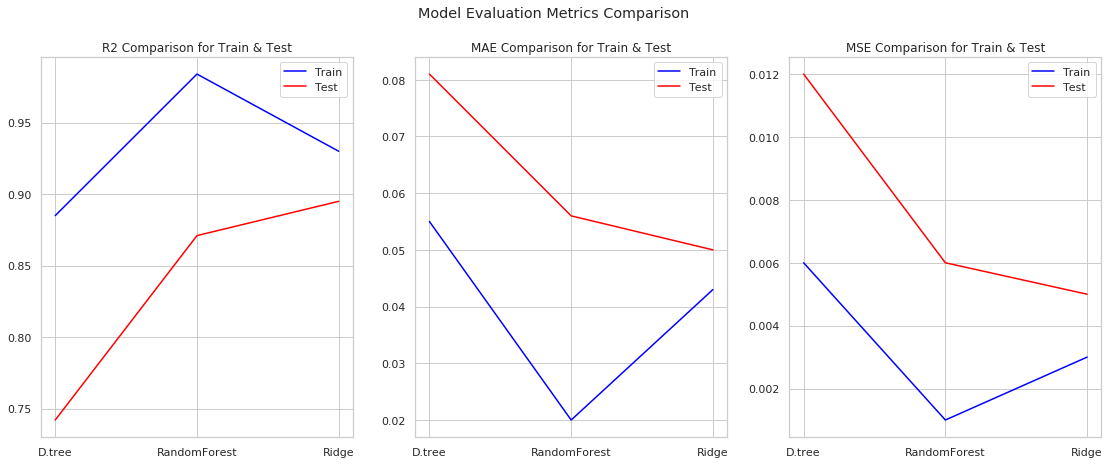

In [61]:
f,ax=plt.subplots(1,3,figsize=(19,7))
sns.lineplot(x=['Ridge','D.tree','RandomForest'], y=[train_rr_r2, train_dtr_r2, train_rfm_r2], color='blue',ax=ax[0], label='Train')
sns.lineplot(x=['Ridge','D.tree','RandomForest'], y=[test_rr_r2, test_dtr_r2, test_rfm_r2], color='red',ax=ax[0], label='Test')
ax[0].set_title('R2 Comparison for Train & Test')

sns.lineplot(x=['Ridge','D.tree','RandomForest'], y=[train_rr_mae, train_dtr_mae, train_rfm_mae], color='blue',ax=ax[1],label='Train')
sns.lineplot(x=['Ridge','D.tree','RandomForest'], y=[test_rr_mae, test_dtr_mae, test_rfm_mae], color='red',ax=ax[1],label='Test')
ax[1].set_title('MAE Comparison for Train & Test')

sns.lineplot(x=['Ridge','D.tree','RandomForest'], y=[train_rr_mse, train_dtr_mse, train_rfm_mse], color='blue',ax=ax[2],label='Train')
sns.lineplot(x=['Ridge','D.tree','RandomForest'], y=[test_rr_mse, test_dtr_mse, test_rfm_mse], color='red',ax=ax[2],label='Test')
ax[2].set_title('MSE Comparison for Train & Test')

plt.suptitle("Model Evaluation Metrics Comparison")

# Conclusion
Finalising based on evaluation metrics plot

* A high R2 score & low values of MSE and MAE is preferred
* Looking at the R2plot, we see Random Forest model gives highest R2 for train data, but relatively low R2 for test data, for D.tree- the difference between its train R2 and test R2 is too much, and for ridge that difference is less.

* For MAE , random forest performs good for train data, but does poorly in test data, while Ridge shows consistant performace for both train and test.

* For MSE also, there is no consistency in the performance of random forest and decision tree, while Ridge performs good for both train and test data i.e. similar values of MSE for both train and test.

* Based on these, though Random Forest gave high R2 and low MAE for train, it failed on test data (overfit), hence Ridge (with alpha =10) is the best model as it performs good for both train and test data.

* **Final Note** : we want a model that is consistant across known and unknown data, hence choosing Ridge Model(alpha=10) which yield similar metrics for both train and test data.

* Thank You
* ~C.Varun~